In [1]:
import pymc
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

## Q1

In [36]:
n = 100; x = stats.t(3,loc = 4, scale = 1).rvs(n)
c = 2
g = 1000

mu, var, V = np.zeros([c,g]), np.zeros([c,g]), np.zeros([c,g])
mu[:,0] = 100
var[:,0] = 50
V[:,0] = 50

rejections_mu = 0
rejections_var = 0
rejections_v = 0
for C in range(c):
    for G in range(1,g):
        mu_not = 5
        tau_not = 0.7
        target_mu = lambda mu_: np.prod(stats.t(V[C,G-1], mu_, var[C,G-1]).pdf(x))*stats.norm(loc=mu_not, scale=1/(tau_not**2)).pdf(mu_)
        proposal_mu = lambda mu_: stats.norm(loc = mu_, scale = 1)
        
        mu_tilda = proposal_mu(mu[C,G-1]).rvs()
        #(target_mu(mu_tilda)/target_mu(mu[C,G-1]))* (proposal_mu(mu_tilda).pdf(mu[C,G-1])/proposal_mu(mu[C,G-1]).pdf(mu_tilda))
        
        log_prob_mu = np.log(target_mu(mu_tilda)) - np.log(target_mu(mu[C,G-1])) + np.log(proposal_mu(mu_tilda).pdf(mu[C,G-1])) - np.log(proposal_mu(mu[C,G-1]).pdf(mu_tilda))
        acc_prob_mu = min(0, log_prob_mu)
        if np.log(stats.uniform().rvs()) < acc_prob_mu:
            mu[C,G] = mu_tilda
            
        else:
            mu[C,G] = mu[C,G-1]
            rejections_mu += 1
            
        
        var_not = 1
        target_var = lambda var_: np.prod(stats.t(V[C,G-1], mu[C,G-1], var_).pdf(x))*stats.halfnorm(scale=var_not).pdf(var_)
        proposal_var = lambda var_: stats.norm(loc = var_, scale = 1)
        
        var_tilda = proposal_var(var[C,G-1]).rvs()
        
        #(target_var(var_tilda)/target_var(var[C,G-1]))* (proposal_var(var_tilda).pdf(var[C,G-1])/proposal_var(var[C,G-1]).pdf(var_tilda))
        
        log_prob_var = np.log(target_var(var_tilda)) - np.log(target_var(var[C,G-1])) + np.log(proposal_var(var_tilda).pdf(var[C,G-1])) - np.log(proposal_var(var[C,G-1]).pdf(var_tilda))
        acc_prob_var = min(0, log_prob_var)
        if np.log(stats.uniform().rvs()) < acc_prob_var:
            var[C,G] = var_tilda
            
        else:
            var[C,G] = var[C,G-1]
            rejections_var += 1
        
        
        target_v = lambda v_: np.prod(stats.t(v_, mu[C,G-1], var[C,G-1]).pdf(x))*stats.randint(low=1,high=100).pmf(v_)
        proposal_v = lambda v_: stats.norm(loc=v_, scale=1)
        
        v_tilda = proposal_v(V[C,G-1]).rvs()
        
        #(target_v(v_tilda)/target_v(V[C,G-1]))* (proposal_v(v_tilda).pdf(V[C,G-1])/proposal_v(V[C,G-1]).pdf(v_tilda))
        
        log_prob_v = np.log(target_v(v_tilda)) - np.log(target_v(V[C,G-1])) + np.log(proposal_v(v_tilda).pdf(V[C,G-1])) - np.log(proposal_v(V[C,G-1]).pdf(v_tilda))
        acc_prob_v = min(0, log_prob_v)
        if np.log(stats.uniform().rvs()) < acc_prob_v:
            V[C,G] = v_tilda
            
        else:
            V[C,G] = V[C,G-1]
            rejections_v += 1 
            

    

            
                          
        
        


/tmp/ipykernel_53/3099689951.py:23: RuntimeWarning: divide by zero encountered in log
  log_prob_mu = np.log(target_mu(mu_tilda)) - np.log(target_mu(mu[C,G-1])) + np.log(proposal_mu(mu_tilda).pdf(mu[C,G-1])) - np.log(proposal_mu(mu[C,G-1]).pdf(mu_tilda))
/tmp/ipykernel_53/3099689951.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  log_prob_mu = np.log(target_mu(mu_tilda)) - np.log(target_mu(mu[C,G-1])) + np.log(proposal_mu(mu_tilda).pdf(mu[C,G-1])) - np.log(proposal_mu(mu[C,G-1]).pdf(mu_tilda))
/tmp/ipykernel_53/3099689951.py:41: RuntimeWarning: divide by zero encountered in log
  log_prob_var = np.log(target_var(var_tilda)) - np.log(target_var(var[C,G-1])) + np.log(proposal_var(var_tilda).pdf(var[C,G-1])) - np.log(proposal_var(var[C,G-1]).pdf(var_tilda))
/tmp/ipykernel_53/3099689951.py:41: RuntimeWarning: invalid value encountered in scalar subtract
  log_prob_var = np.log(target_var(var_tilda)) - np.log(target_var(var[C,G-1])) + np.log(proposal_var(var_tilda).pdf

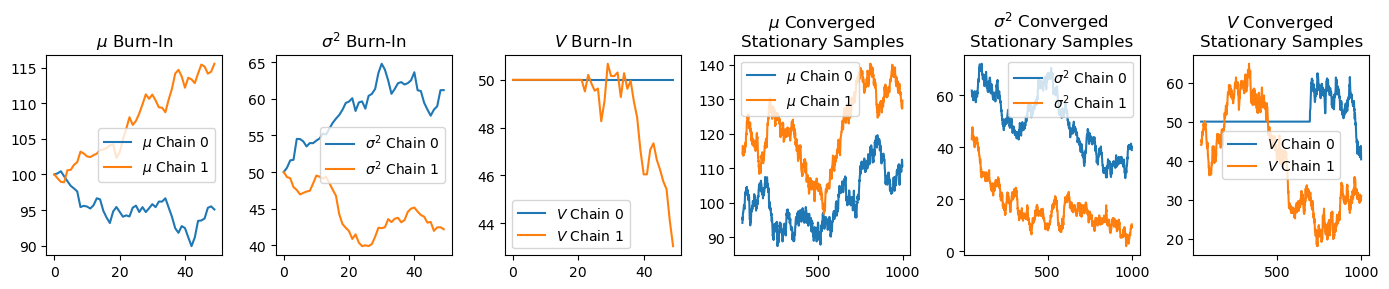

In [37]:
fig,ax = plt.subplots(1, 6, figsize=(14,3)); ax[0].set_title("$\\mu$ Burn-In"); ax[1].set_title("$\\sigma^2$ Burn-In");ax[2].set_title("$V$ Burn-In"); ax[3].set_title("$\\mu$ Converged \nStationary Samples"); ax[4].set_title("$\\sigma^2$ Converged \nStationary Samples");ax[5].set_title("$V$ Converged \nStationary Samples")
burn = 50
demo = 1000
for C in range(c):
    ax[0].plot(mu[C,:burn], label="$\\mu$ Chain "+str(C))
    ax[1].plot(var[C,:burn], label="$\\sigma^2$ Chain "+str(C))
    ax[2].plot(V[C,:burn], label="$V$ Chain "+str(C))
    
    ax[3].plot(np.arange(burn, demo, dtype=int), mu[C,burn:demo], label="$\\mu$ Chain "+str(C))
    ax[4].plot(np.arange(burn, demo, dtype=int), var[C,burn:demo], label="$\\sigma^2$ Chain "+str(C))
    ax[5].plot(np.arange(burn, demo, dtype=int), V[C,burn:demo], label="$V$ Chain "+str(C))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); ax[4].legend(); ax[5].legend()

plt.tight_layout()
#plt.subplots_adjust(wspace=0.8)  # Increase horizontal space between subplots



Although the degrees of freedom parameter seems to converge well, there is poor convergence on the side of both 'mu' and 'sigma^2'. It's possible that this is due to an insufficient step size which traps the chain in the tail regions. It is also possible that our proposal is not suitable to properly explore our target. 

95% credible intervals

In [38]:
#credible interval for Mu
np.quantile(mu[1], [0.025,0.975])

array([100.84271035, 138.23622734])

In [39]:
#credible interval for Sigma^2
np.quantile(var[1],[0.025,0.975])

array([ 5.49789675, 44.6069084 ])

In [40]:
#credible interval for 
np.quantile(V[1],[0.025,0.975])

array([20.64135667, 60.52702001])

In [41]:
#rejection rate for mu
rejections_mu/g

0.0

In [42]:
#rejection rate for var
rejections_var/g

0.0

In [43]:
#rejection rate for v
rejections_v/g

0.715

The rejection rates are quite low for mu and var which may suggest a strong dependence structure. This could hint towards why convergence was not reached. Maybe more than a small step size the issue is not having a large enough perturbation to explore high density regions at the risk of a higher rejection rate. Only degrees of freedom has a rejection rate of 71.5% which indicates sufficient exploration. This is shown in the convergence of degrees of freedom.

## Q2

Let us implement the metropolis within gibbs using the pymc package

In [44]:
#first, we'll define the model with 100 samples

#100 samples
x_1 = stats.t(3, loc= 4, scale = 1).rvs(100)

model_tnorm = pymc.Model()

with model_tnorm:
    mu_not = 5
    tau_not = 0.7
    muu = pymc.Normal('muu', mu = mu_not, sigma = 1/(tau_not**2))
    
    var_not = 1
    var = pymc.HalfNormal('var', sigma = var_not)
    
    V = pymc.DiscreteUniform('V',1, 100)
    
    #likelihood
    x_obs = pymc.StudentT('x', nu = V, mu = muu, sigma = var, observed = x)
    
    
    #metropolis
    def log_accept(logp_diff):
        log_u = np.log(np.random.uniform())  # Sample log U ~ log(0,1)
        return logp_diff > log_u
    
    step1 = pymc.Metropolis(vars=[muu],accept_func = log_accept)
    step2 = pymc.Metropolis(vars=[var],accept_func = log_accept)
    step3 = pymc.Metropolis(vars=[V],accept_func = log_accept)
    
    data_MH = pymc.sample(draws=10000, tune = 1000, chains = 4, step = [step1,step2,step3], return_inferencedata=True)

    


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muu]
>Metropolis: [var]
>Metropolis: [V]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [45]:
az.summary(data_MH, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,20.06598,25.01184,2.00000,78.00000,0.96428,0.68214,630.63630,1007.94515,1.01547
muu,4.08105,0.12727,3.83931,4.31693,0.00159,0.00112,6438.02957,6459.40832,1.00077
var,1.15581,0.17599,0.82628,1.45681,0.00646,0.00457,755.24905,1728.33042,1.01354


there are convergence problems when it comes to V and var. This is implied by the very large high density interval of V. Var's high density interval is still smaller, but its ess_tail is higher than ess_bulk suggesting better tail exploration. muu converges pretty well, with good bulk and tail exploration as per the ess.

In [46]:
# 500 samples
x_2 = stats.t(3, loc= 4, scale = 1).rvs(500)

model_tnorm_2 = pymc.Model()

with model_tnorm_2:
    mu_not = 5
    tau_not = 0.7
    muu = pymc.Normal('muu', mu = mu_not, sigma = 1/(tau_not**2))
    
    var_not = 1
    var = pymc.HalfNormal('var', sigma = var_not)
    
    V = pymc.DiscreteUniform('V',1, 100)
    
    #likelihood
    x_obs = pymc.StudentT('x', nu = V, mu = muu, sigma = var, observed = x_2)
    
    
    #metropolis
    def log_accept(logp_diff):
        log_u = np.log(np.random.uniform())  # Sample log U ~ log(0,1)
        return logp_diff > log_u
    
    step1 = pymc.Metropolis(vars=[muu],accept_func = log_accept)
    step2 = pymc.Metropolis(vars=[var],accept_func = log_accept)
    step3 = pymc.Metropolis(vars=[V],accept_func = log_accept)
    
    data_MH_2 = pymc.sample(draws=10000, tune = 1000, chains = 4, step = [step1,step2,step3], return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muu]
>Metropolis: [var]
>Metropolis: [V]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.


In [47]:
az.summary(data_MH_2, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,3.48972,0.62250,3.00000,4.00000,0.01321,0.00934,2203.29577,2212.99321,1.00164
muu,4.00574,0.05413,3.90424,4.10436,0.00076,0.00054,5042.51695,5179.76511,1.00114
var,1.00368,0.05719,0.90252,1.11175,0.00130,0.00092,1971.85637,3312.69978,1.00102


When we change the sample size from 100 to 500 we see that 'V' converges properly now. In fact, the mean value is much smaller than the previous result where it was almost '20' (6 times the current value). Even the high density interval is reasonable. The ess_bulk is much higher for var and V, both now showing good convergence. The sample size made a significant difference. As before, Var's tail is still better explored than its bulk.

In [48]:
# Sample size = 1000

x_3 = stats.t(3, loc= 4, scale = 1).rvs(1000)

model_tnorm_3 = pymc.Model()

with model_tnorm_3:
    mu_not = 5
    tau_not = 0.7
    muu = pymc.Normal('muu', mu = mu_not, sigma = 1/(tau_not**2))
    
    var_not = 1
    var = pymc.HalfNormal('var', sigma = var_not)
    
    V = pymc.DiscreteUniform('V',1, 100)
    
    #likelihood
    x_obs = pymc.StudentT('x', nu = V, mu = muu, sigma = var, observed = x_3)
    
    
    #metropolis
    # Define custom log acceptance function
    def log_accept(logp_diff):
        log_u = np.log(np.random.uniform())  # Sample log U ~ log(0,1)
        return logp_diff > log_u  # Accept if log probability is greater
    
    step1 = pymc.Metropolis(vars=[muu], accept_func = log_accept, scaling = 0.1)
    step2 = pymc.Metropolis(vars=[var],accept_func = log_accept, scaling=0.1)
    step3 = pymc.Metropolis(vars=[V],accept_func = log_accept, scaling=0.1)
    
    data_MH_3 = pymc.sample(draws=10000, tune = 1000, chains = 4, step = [step1,step2,step3], return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muu]
>Metropolis: [var]
>Metropolis: [V]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.


In [49]:
az.summary(data_MH_3, round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V,3.30452,0.46898,3.00000,4.0000,0.01055,0.00746,1985.87235,1969.25703,1.00206
muu,4.01279,0.04050,3.93452,4.0856,0.00044,0.00031,8652.83567,9264.31571,1.00056
var,1.05109,0.04609,0.97078,1.1386,0.00095,0.00068,2489.67095,5508.75079,1.00181


This is the best result with a sample size of 1000, with convergence of all parameters and high ess_bulks for all parameters. Although, none of the ess_bulks come anywhere close to the 40,000 draws made. This suggests a strong internal dependency structre that the metropolis hastings algorithm was not able to overcome. 

The estimates of hdi are also very different from our credible interval estimates from Q1. This is likely due to the manual selection of proposal distributions in Q1 which were probably not good ones. Moreover, we only did 1000 iterations in the algorithm for Q1 because it was taking too much time for 10,000 iterations. 

All in all, higher sample size does make a difference but our algoirthms were not able to reach a stationary distribution as indicated by the low ess_bulk. 